## MLP Classifier
### Joseph Bentivegna

This project implements a MLP classifier in Python using Tensorflow. The project has 3 hidden layers and uses an eLu activation function to introduce non-linearity. Data generation was done by uniformingly sampling thetas, calculating x and y values, and then applying a class value to each point. The MLP graph was created by first initializing 3 sets of weights and biases and then constructing a network of alternating hidden and activation layers. ReLu was used first in the activation layers but after testing, eLu was found to work better. To train the model, 100,000 iterations of data were passed to the optimizer in order to minimize the loss function. We chose to use sigmoid cross entropy for our loss function in order to conditionally calculate the loss based on what the actual class is. L2 Penalty was also implemented to penalize very large weights. A contour map was used in order to plot the decision boundry of the network and show accuracy. 

In [1]:
# imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# define batch size
BATCH_SIZE = 100
NUM_BATCHES = 100000
LAMBDA = .01

In [3]:
# initialize Data class
class Data(object):
    def __init__(self):
        num_samp = 250       # NOTE: this is per-class
        sigma = .5
        np.random.seed(12345)

        self.index = np.arange(2*num_samp)
        self.theta = np.random.uniform(np.pi/3, 4*np.pi, 2*num_samp)
        self.r1 = 2*self.theta[:num_samp] + np.random.normal(0,sigma,num_samp)
        self.r2 = -2*self.theta[num_samp:] + np.random.normal(0,sigma,num_samp)
        self.r = np.concatenate((self.r1,self.r2), axis=0)
        
        # primary data vectors are 'points' (containing x,y pairs) and 'choice' (the classification)
        self.points = np.transpose(np.vstack((self.r*np.cos(self.theta), self.r*np.sin(self.theta))))
        self.choice = np.concatenate((np.zeros(num_samp), np.ones(num_samp)), axis=0)
        
    def get_batch(self):
        choices = np.random.choice(self.index, size=BATCH_SIZE)
    
        return self.points[choices,:], self.choice[choices]

In [4]:
def f(points):
    # length of each hidden layer
    leng1, leng2 = 50, 25
    
    # initialize weights and biases
    w1 = tf.get_variable('w1', [2,leng1], tf.float32, tf.random_normal_initializer())
    b1 = tf.get_variable('b1', [1,leng1], tf.float32, tf.zeros_initializer())
    w2 = tf.get_variable('w2', [leng1,leng2], tf.float32, tf.random_normal_initializer())
    b2 = tf.get_variable('b2', [1,leng2], tf.float32, tf.zeros_initializer())
    w3 = tf.get_variable('w3', [leng2,1], tf.float32, tf.random_normal_initializer())
    b3 = tf.get_variable('b3', [1,1], tf.float32, tf.zeros_initializer())
     
    # construct network
    lev1 = tf.matmul(points, w1) + b1
    activ1 = tf.nn.elu(lev1)
    lev2 = tf.matmul(activ1, w2) + b2
    activ2 = tf.nn.elu(lev2)
    lev3 = tf.matmul(activ2, w3) + b3
    
    return tf.squeeze(lev3)

In [5]:
# initialize placeholders for x, y, class batches
points = tf.placeholder(tf.float32, [None,2])
choice = tf.placeholder(tf.int32, [None])
y_hat = f(points)

# define loss function and L2 penalty
loss = tf.losses.sigmoid_cross_entropy(choice, y_hat) + (LAMBDA*tf.reduce_sum([tf.nn.l2_loss(v) for v in tf.trainable_variables()]))

# gradient descent to optimize our parameters by minimizing our loss function
optim = tf.train.GradientDescentOptimizer(learning_rate=0.01).minimize(loss)
init = tf.global_variables_initializer()

# initialize session
sess = tf.Session()
sess.run(init)

data = Data()

# loop through batches and run gradient descent to tune our parameters
for _ in tqdm(range(0, NUM_BATCHES)):
    points_val, choice_val = data.get_batch()
    loss_np, _ = sess.run([loss, optim], feed_dict={points: points_val, choice: choice_val})

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:43<00:00, 612.59it/s]


In [6]:
# testing case: print out true classes and predicted classes
points_val, choice_val = data.get_batch()
outs = sess.run(y_hat, feed_dict={points: points_val})
pick = sess.run(tf.sigmoid(outs))
classify = np.round(pick)

# print (choice_val, "\n", pick, "\n", classify, "\n")
# print (choice_val- classify)
# print (sum(abs(choice_val-classify)))

In [7]:
# setup plotting data
x = y = np.linspace(-25,25,300)
xx, yy = np.meshgrid(x,y)
allp = np.array(list(zip(xx.flatten(), yy.flatten())))

outs = sess.run(y_hat, feed_dict={points: allp})
pick = sess.run(tf.sigmoid(outs))

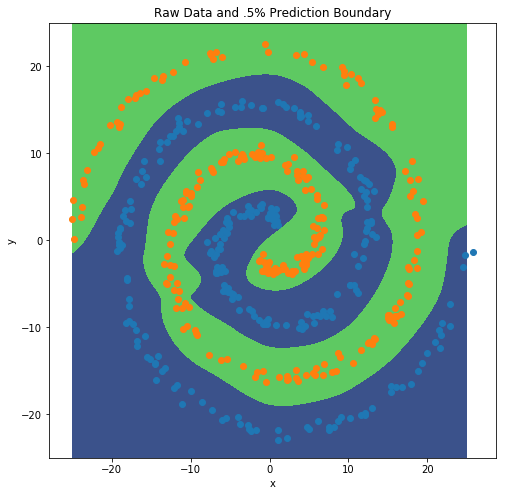

In [8]:
# plot
fig, axarr = plt.subplots(nrows=1, ncols=1, figsize=[8,8])
plt.contourf(xx, yy, pick.reshape(xx.shape), [0,.5,1])
plt.scatter(data.points[:250,0], data.points[:250,1])
plt.scatter(data.points[250:,0], data.points[250:,1])

axarr.set_title('Raw Data and .5% Prediction Boundary')
axarr.set(xlabel='x', ylabel='y')

plt.show()